# Deep Neural Network with tensorflow and keras - CIFAR 10
## Summary:
First try: with tensorflow DNN: only 29.5% test accuracy

Second try: Trained a DNN with keras to achieve 52% test accuracy.

## First Try:

### Import Libraries

In [27]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf



def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

In [28]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [29]:
n_inputs = 3072 
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [30]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Import Data

In [31]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
X_train, X_vali, y_train, y_vali = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

In [32]:
from keras.utils import np_utils
train_features = X_train.astype('float32')/255
vali_features = X_vali.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
y_train1 = y_train.reshape(-1,)
y_valid1 = y_vali.reshape(-1,)
y_test1 = test_labels.reshape(-1,)
X_train1=train_features.reshape(40000,3072)
X_valid1=vali_features.reshape(10000,3072)
X_test1=test_features.reshape(10000,3072)

In [34]:
n_epochs = 100
batch_size = 25

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./CIFAR.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./CIFAR.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 1.970600	Best loss: 1.970600	Accuracy: 29.22%
1	Validation loss: 2.005341	Best loss: 1.970600	Accuracy: 24.32%
2	Validation loss: 2.431177	Best loss: 1.970600	Accuracy: 9.96%
3	Validation loss: 2.364594	Best loss: 1.970600	Accuracy: 10.15%
4	Validation loss: 2.346147	Best loss: 1.970600	Accuracy: 10.15%
5	Validation loss: 2.364898	Best loss: 1.970600	Accuracy: 10.30%
6	Validation loss: 2.409799	Best loss: 1.970600	Accuracy: 9.33%
7	Validation loss: 2.378439	Best loss: 1.970600	Accuracy: 9.94%
8	Validation loss: 2.344973	Best loss: 1.970600	Accuracy: 10.15%
9	Validation loss: 2.348330	Best loss: 1.970600	Accuracy: 10.17%
10	Validation loss: 2.442215	Best loss: 1.970600	Accuracy: 9.79%
11	Validation loss: 2.416412	Best loss: 1.970600	Accuracy: 9.73%
12	Validation loss: 2.351593	Best loss: 1.970600	Accuracy: 10.30%
13	Validation loss: 2.457614	Best loss: 1.970600	Accuracy: 10.23%
14	Validation loss: 2.437144	Best loss: 1.970600	Accuracy: 9.96%
15	Validation loss: 2.4463

## Second Try:

## Import Libraries and Data

In [1]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Show image example for each class

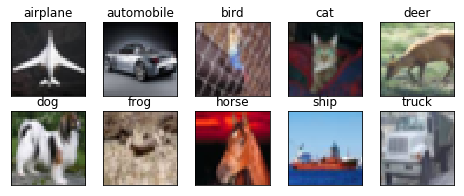

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::], (1, 2, 0))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [5]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Neural Network

In [6]:
train_features=train_features.reshape(50000,3072)
test_features=test_features.reshape(10000,3072)

### Network uses Nesterov accelerated gradient descent, ELU and ReLU activation layers

In [26]:
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(units=128,activation="elu",input_shape=(3072,)))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=128,activation="elu"))
model.add(Dense(units=128,activation="elu"))
model.add(Dense(units=10,activation="softmax"))

sgd = SGD(lr=0.005, decay=1e-5, momentum=0.85, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.fit(train_features,train_labels,batch_size=25,epochs=25,verbose=1)
accuracy = model.evaluate(x=test_features,y=test_labels,batch_size=25)
print("Accuracy: ",accuracy[1])

Epoch 1/25
50000/50000 [==============================] - 12s 235us/step - loss: 1.7825 - acc: 0.3549
Epoch 2/25
50000/50000 [==============================] - 11s 224us/step - loss: 1.5892 - acc: 0.4283
Epoch 3/25
50000/50000 [==============================] - 11s 225us/step - loss: 1.5042 - acc: 0.4583
Epoch 4/25
50000/50000 [==============================] - 11s 225us/step - loss: 1.4460 - acc: 0.4784
Epoch 5/25
50000/50000 [==============================] - 11s 225us/step - loss: 1.4019 - acc: 0.4963
Epoch 6/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.3633 - acc: 0.5116
Epoch 7/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.3284 - acc: 0.5245
Epoch 8/25
50000/50000 [==============================] - 11s 224us/step - loss: 1.2982 - acc: 0.5350
Epoch 9/25
50000/50000 [==============================] - 11s 224us/step - loss: 1.2687 - acc: 0.5451
Epoch 10/25
50000/50000 [==============================] - 11s 223us/step - loss: 